# Projeto - Machine Learning I
#### `Professor`: Alex Lima

Este documento descreve os requisitos e critérios de avaliação para projeto de Machine Learning I.

A principal finalidade deste projeto é fazer com o aluno pratique a exploração e modelagem de dados apresentados ao longo do modelo de machine learning I. Assim, durante o planejamento e desenvolvimento de seu projeto, recomenda-se visitar a ementa do módulo e mapear em seu projeto os itens previstos e lecionados em aula.

**DESAFIO**: Seu desafio neste módulo é conhecer uma área de negócio ou ciência de seu interesse e propor uma solução por meio de um modelo de machine learning. A solução deve ser apresentada prlo grupo no último dia de aula e detalhada em um report (jupyter notebook). Como referência, a equipe pode seguir os passos descritos a seguir:
 - `Introdução`
     > Descreva a área e a solução proposta em seu projeto
 - `Coleta de dados`
     > Busque ou construa um dataset relacionado ao problema que deseja solucionar.
 - `Desenvolvimento`
     > Desenvolva um modelo de machine learning, utilizando o algoritmo de sua escolha. Inclua métricas e visualizações que tornem seu modelo atrativo e compreensível para que não é da área de dados.
 - `Apresentação`
     > A apresentação deve ocorrer no último dia de aula (29/04). A equipe terá até 20 minutos para apresentar sua solução.
  
### Bons estudos! Sucesso!


####
# Problema de Negócio

O Banco Santander está com um novo produto em sua carteira de investimentos. 

A fim de obter um ROI (*return on investiment*) sigificativo nesta campanha, o diretor de vendas do Banco Santander, Alex Lima, contratou a empresa `FLMP Consultorias` para desenvolver um modelo preditivo que identifique entre seus pontenciais clientes aqueles que possuem a maior probabilidade de fazer uma aplicação neste novo produto.

Desta forma, sua equipe de telemarketing poderá obter resultados muito eficientes e tirar sua corda do pescoço!

####
## Imports

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from warnings import filterwarnings
filterwarnings("ignore")

####
## Funções para EDA

**Identidade visual**

In [2]:
colors = ["#d9ed92", "#b5e48c", "#99d98c", "#76c893", "#52b69a", "#34a0a4", "#168aad", "#1a759f", "#1e6091", "#184e77", "#123a59", "#0f304a"]
title_fontsize = 18
title_fontweight = 1000

**Plotagem de gráficos**

In [3]:
def grafico_pizza(data: pd.core.series.Series, labels: pd.core.series.Series, title: str, ax=None) -> None:
    """
    Esta função plota um gráfico de pizza.    

    Parâmetros:
    - `data`: recebe um objeto do tipo Série do Pandas, referente aos dados.
    - `labels`: recebe um objeto do tipo Série do Pandas, referente aos rótulos.
    - `title`: recebe uma string referente ao título do gráfico.
    """
    if not ax:    
        plt.figure(figsize=(6, 6))
        plt.title(title, fontsize=title_fontsize, fontweight=title_fontweight)
        ax = plt
    else:
        ax.set_title(title, fontsize=title_fontsize, fontweight=title_fontweight)

    ax.pie(
        data,
        explode=[0.1] + [0] * (len(data) - 1),
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
    )


def grafico_barra(x: pd.core.series.Series, y: pd.core.series.Series, title: str, ax=None) -> None:
    """
    Esta função plota um gráfico de barra.    

    Parâmetros:
    - `data`: recebe um objeto do tipo Série do Pandas, referente aos dados.
    - `labels`: recebe um objeto do tipo Série do Pandas, referente aos rótulos.
    - `title`: recebe uma string referente ao título do gráfico.
    """

    if not ax:    
        plt.figure(figsize=(8, 6))
        plt.title(title, fontsize=title_fontsize, fontweight=title_fontweight)
        plt.xticks(rotation=45)
        ax = plt
    else:
        ax.set_title(title, fontsize=title_fontsize, fontweight=title_fontweight)
        ax.set_xticklabels(x, rotation=45)

    ax.bar(x, y, color=colors)

**Outras**

In [4]:
def features_freq_by_target(dataframe: pd.core.frame.DataFrame, target: str, *features: str, target_condition=None, normalize=True, sort_ascending=True) -> pd.core.frame.DataFrame:
    """
    Esta função retorna um dataframe contendo as frequências relativas de um grupo de features de um dataframe em relação a um target do mesmo dataframe.

    Parâmetros:
    - `dataframe`: recebe um objeto do tipo DataFrame do Pandas.
    - `target`: recebe uma string referente à coluna de target.
    - `features`: recebe uma ou mais strings indicando as colunas do DataFrame das quais se deseja obter as frequências em relação ao target.
    - `target_condition` (opcional, não definido por padrão): recebe uma string referente a um valor do target, a ser passado como filtro.
    - `sort_ascending` (opcional, normalizado por padrão): recebe um valor booleano (True ou False) que define a normalização dos dados em porcentagem.
    - `sort_ascending` (opcional, ascendente por padrão): recebe um valor booleano (True ou False) que define a ordenação dos dados.
    """

    result = dataframe.groupby(list(features))[target].value_counts(normalize=normalize)
    if normalize:
        result *= 100
        
    result = result.sort_values(ascending=sort_ascending).reset_index()

    if target_condition:
        mask = result[target] == target_condition
        return result[mask].drop(target, axis=1)
    else:
        if normalize:
            return result

        result = result.groupby(list(features)).sum().sort_values(by="count", ascending=sort_ascending).reset_index()
        
        if len(features) > 1:
            return result
        else:
            return result.drop(target, axis=1)


def interval_presentation(age: pd._libs.interval.Interval) -> pd._libs.interval.Interval:
    """
    Esta função arredonda os intervalos e os formata para uma melhor apresentação visual.    

    Parâmetros:
    - `age`: recebe um objeto do tipo Intervalo do Pandas.
    """
    
    interval = pd.Interval(left=(round(age.left)), right=(round(age.right)))
    return f"{interval.left} a {interval.right}"

####
## Funções para cálculo das métricas

In [5]:
def metricas(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"""
    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO
    ===============================================

    Acurácia:   {acc}
    Precisão:   {pre}
    Revocação:  {rec}
    F1-Score:   {f1}
    AUC:        {auc}
    """)

def plot_matriz_confusao(y_test, y_pred):
    conf_mtx = confusion_matrix(y_test, y_pred)

    sns.heatmap(conf_mtx, annot=True, fmt="d")
    
    plt.title("Matriz de confusão", fontsize=16, fontweight=800, y=1.05)
    plt.ylabel("Real")
    plt.xlabel("Predito")
    
    plt.show()

def plot_roc_auc(model, X_test, y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    reta = np.arange(0, 1.2, 0.2)

    plt.plot(reta, reta, linestyle="dashed")
    plt.plot(fpr, tpr, color="red")
    
    plt.margins(0, 0)
    plt.fill_between(fpr, tpr, color="#faf7cf")
    
    plt.title("Curva ROC-AUC", fontweight=800, fontsize=16, y=1.05)
    plt.xlabel("Taxa de falsos positivos")
    plt.ylabel("Taxa de verdadeiros positivos")
    plt.legend(["Chances aleatórias", "Curva ROC"])
    
    plt.show()

####
## Análise exploratória dos dados

### Análise inicial

In [6]:
df = pd.read_csv("bank-full.csv", delimiter=";")

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
df.shape

(45211, 17)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#####
### Relação entre features e target

**Convertidos por faixa de idade**

In [10]:
age_quantiles = pd.qcut(df["age"], 4).apply(interval_presentation)
ages_converted = features_freq_by_target(df, "y", age_quantiles, target_condition="yes", sort_ascending=False)
display(ages_converted)

,age,proportion
4,18 a 33,13.620729
5,48 a 95,13.282088
6,33 a 39,10.302559
7,39 a 48,9.023544


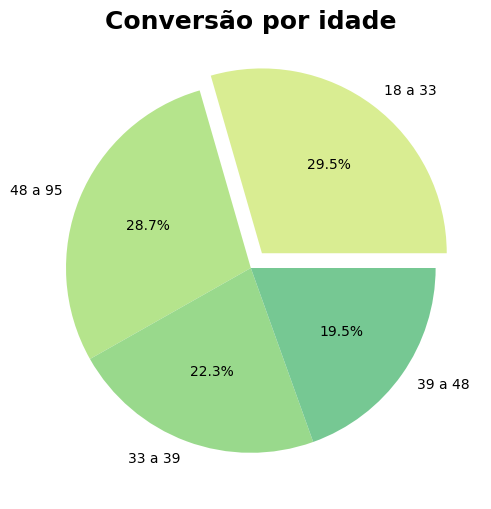

In [11]:
grafico_pizza(ages_converted["proportion"], ages_converted["age"], "Conversão por idade")

#####
**Convertidos por ocupação**

In [12]:
jobs_distribution = features_freq_by_target(df, "y", "job", normalize=False, sort_ascending=False)
display(jobs_distribution)

,job,count
0,blue-collar,9732
1,management,9458
2,technician,7597
3,admin.,5171
4,services,4154
5,retired,2264
6,self-employed,1579
7,entrepreneur,1487
8,unemployed,1303
9,housemaid,1240


In [13]:
jobs_converted = features_freq_by_target(df, "y", "job", target_condition="yes", sort_ascending=False)
display(jobs_converted)

,job,proportion
12,student,28.678038
13,retired,22.791519
14,unemployed,15.502686
15,management,13.755551
16,admin.,12.202669
17,self-employed,11.842939
18,unknown,11.805556
19,technician,11.056996
20,services,8.883004
21,housemaid,8.790323


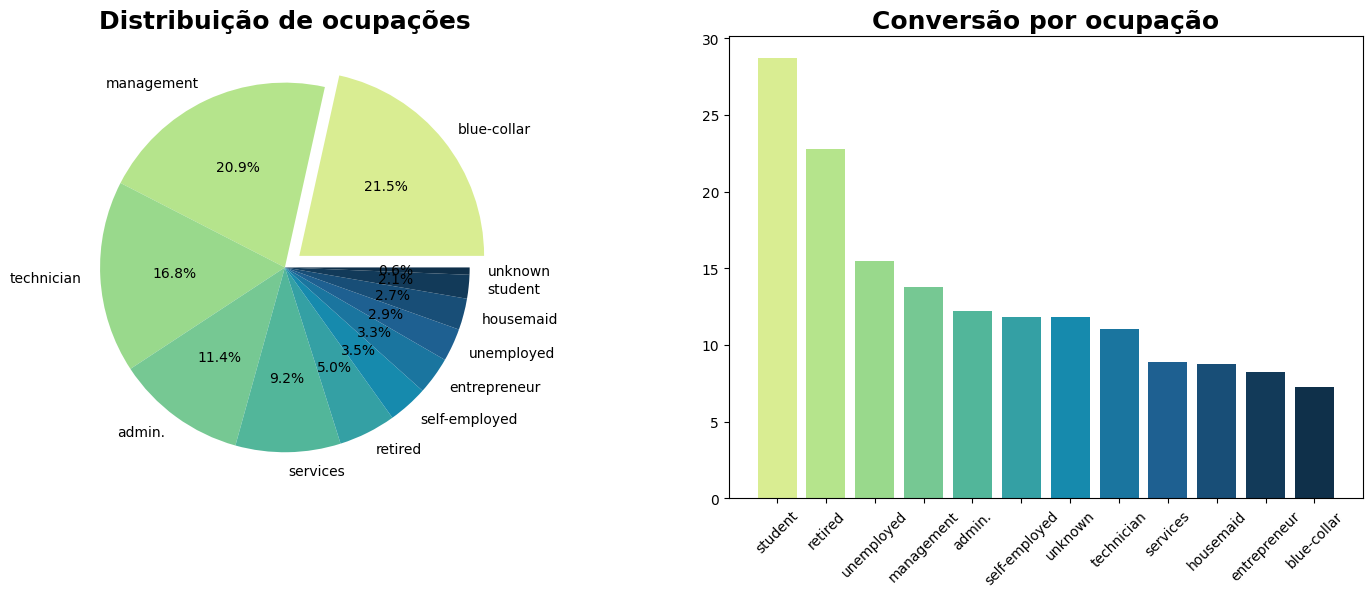

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

grafico_pizza(jobs_distribution["count"], jobs_distribution["job"], "Distribuição de ocupações", ax=ax1)
grafico_barra(jobs_converted["job"], jobs_converted["proportion"], "Conversão por ocupação", ax=ax2)

#####
**Convertidos por estado civil**

In [15]:
marital_status_converted = features_freq_by_target(df, "y", "job", target_condition="yes", sort_ascending=False)
display(marital_status_converted)

,job,proportion
12,student,28.678038
13,retired,22.791519
14,unemployed,15.502686
15,management,13.755551
16,admin.,12.202669
17,self-employed,11.842939
18,unknown,11.805556
19,technician,11.056996
20,services,8.883004
21,housemaid,8.790323


In [16]:
target_features_analysis(df, "y", "default")

NameError: name 'target_features_analysis' is not defined

In [ ]:
balance_quantiles = pd.qcut(df["balance"], 4)
target_features_analysis(df, "balance_quantiles", "education")

In [ ]:
df["balance_quantiles"] = pd.qcut(df["balance"], 4)

In [ ]:
df.groupby("education")["balance_quantiles"].value_counts(normalize=True)

In [ ]:
df.groupby("marital")["y"].value_counts(normalize=True) * 100

In [ ]:
df.groupby("housing")["y"].value_counts(normalize=True) * 100

In [ ]:
df.groupby("loan")["y"].value_counts(normalize=True) * 100

In [ ]:
df.groupby("balance_quantiles")["y"].value_counts(normalize=True)

####
## Pre-processamento

In [17]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [18]:
df["default"].unique(), df["housing"].unique(), df["loan"].unique(), df["y"].unique()

(array(['no', 'yes'], dtype=object),
 array(['yes', 'no'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object))

In [19]:
df["default"] = np.where(df["default"] == "yes", 1, 0)
df["housing"] = np.where(df["housing"] == "yes", 1, 0)
df["loan"] = np.where(df["loan"] == "yes", 1, 0)
df["y"] = np.where(df["y"] == "yes", 1, 0)

In [21]:
df["education"].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [22]:
df["education"] = np.where(df["education"] == "unknown", 0,
                           np.where(df["education"] == "primary", 1,
                                   np.where(df["education"] == "secondary", 2, 3)))

In [23]:
df["month"].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [24]:
months = {
    "jan": 0,
    "feb": 1,
    "mar": 2,
    "apr": 3,
    "may": 4,
    "jun": 5,
    "jul": 6,
    "aug": 7,
    "sep": 8,
    "oct": 9,
    "nov": 10,
    "dec": 11,
}

df["month"] = df["month"].apply(lambda month: months[month])

In [25]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,3,0,2143,1,0,unknown,5,4,261,1,-1,0,unknown,0
1,44,technician,single,2,0,29,1,0,unknown,5,4,151,1,-1,0,unknown,0
2,33,entrepreneur,married,2,0,2,1,1,unknown,5,4,76,1,-1,0,unknown,0
3,47,blue-collar,married,0,0,1506,1,0,unknown,5,4,92,1,-1,0,unknown,0
4,33,unknown,single,0,0,1,0,0,unknown,5,4,198,1,-1,0,unknown,0


In [26]:
X_with_dummies = pd.get_dummies(
    df,
    columns=["job", "marital", "contact", "poutcome"]
).drop("y", axis=1)

In [27]:
X_with_dummies.T

,0,1,2,3,4,5,6,7,8,9,...,45201,45202,45203,45204,45205,45206,45207,45208,45209,45210
age,58,44,33,47,33,35,28,42,58,43,...,53,34,23,73,25,51,71,72,57,37
education,3,2,2,0,0,3,3,3,1,2,...,3,2,3,2,2,3,1,2,2,2
default,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
balance,2143,29,2,1506,1,231,447,2,121,593,...,583,557,113,2850,505,825,1729,5715,668,2971
housing,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
loan,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
day,5,5,5,5,5,5,5,5,5,5,...,17,17,17,17,17,17,17,17,17,17
month,4,4,4,4,4,4,4,4,4,4,...,10,10,10,10,10,10,10,10,10,10
duration,261,151,76,92,198,139,217,380,50,55,...,226,224,266,300,386,977,456,1127,508,361
campaign,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,2,3,2,5,4,2


####
## Modelos

### Separação entre treino e teste

In [28]:
X = X_with_dummies
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelo 1 - Regressão Logística

In [30]:
model_logreg = LogisticRegression(max_iter=1_000).fit(X_train, y_train)

In [31]:
y_pred = model_logreg.predict(X_test)

In [32]:
metricas(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.8949424948392805
    Precisão:   0.6220028208744711
    Revocação:  0.2759699624530663
    F1-Score:   0.3823146944083225
    AUC:        0.6267865857727475
    


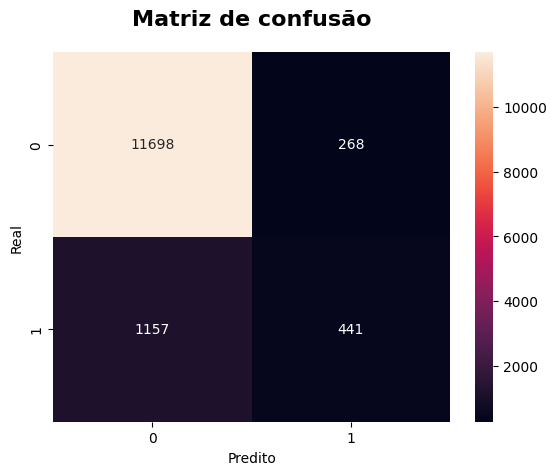

In [33]:
plot_matriz_confusao(y_test, y_pred)

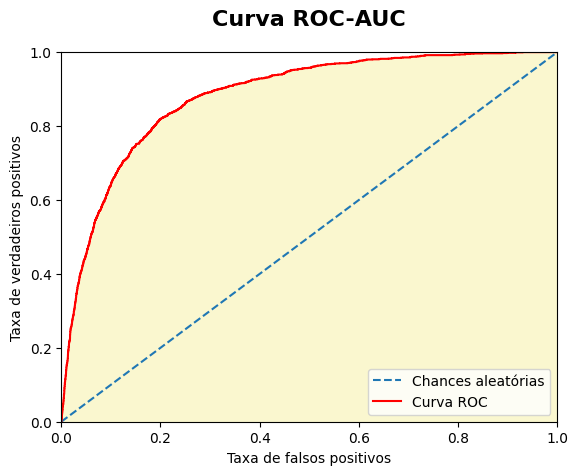

In [34]:
plot_roc_auc(model_logreg, X_test, y_test, y_pred)

### Modelo 2 - Árvore de decisão

In [35]:
model_dectree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [36]:
y_pred = model_dectree.predict(X_test)

In [37]:
metricas(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.873267472721911
    Precisão:   0.4632665452337584
    Revocação:  0.47747183979974966
    F1-Score:   0.4702619414483821
    AUC:        0.7017979289254473
    


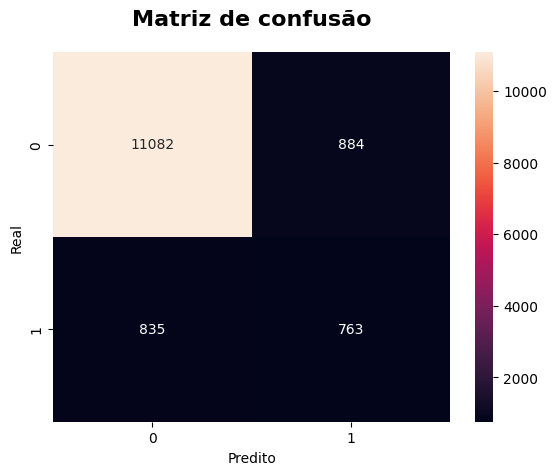

In [38]:
plot_matriz_confusao(y_test, y_pred)

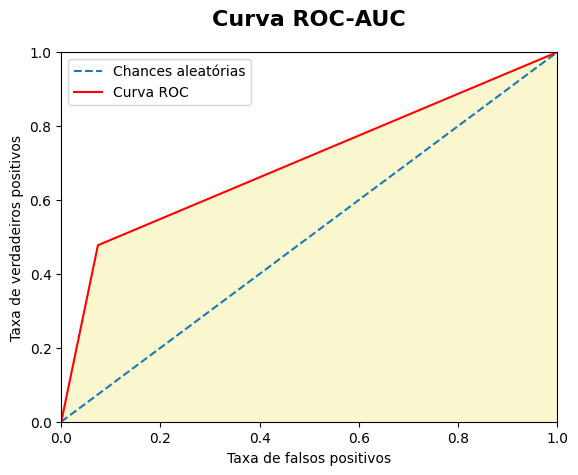

In [40]:
plot_roc_auc(model_dectree, X_test, y_test, y_pred)

#### Ajuste de hiperparâmetros utilizando o GridSearch

In [51]:
model_gscv = DecisionTreeClassifier()

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 10, 50, 100],
    "min_impurity_decrease": [0.0, 0.05, 0.1],
    "ccp_alpha": [0.0, 0.05, 0.1],
    "monotonic_cst": [None, -1, 0, 1]
}

In [55]:
grid_search = GridSearchCV(
    estimator=model_gscv,
    param_grid=param_grid,
    cv=2,
    verbose=1,
    n_jobs=-1
).fit(X_train, y_train)

Fitting 2 folds for each of 62208 candidates, totalling 124416 fits


In [56]:
print("Melhores parâmetros:\n", grid_search.best_params_)

Melhores parâmetros:
 {'ccp_alpha': 0.0, 'criterion': 'log_loss', 'max_depth': 10, 'max_features': 'log2', 'max_leaf_nodes': 100, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 10, 'monotonic_cst': None, 'splitter': 'best'}


In [57]:
print("Melhores parâmetros:\n", grid_search.best_score_)

Melhores parâmetros:
 0.8986634492084355


In [58]:
best_model_dectree = grid_search.best_estimator_

In [59]:
y_pred = best_model_dectree.predict(X_test)

In [60]:
metricas(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.8913299911530522
    Precisão:   0.6065292096219931
    Revocação:  0.22090112640801002
    F1-Score:   0.3238532110091743
    AUC:        0.6008817849990911
    


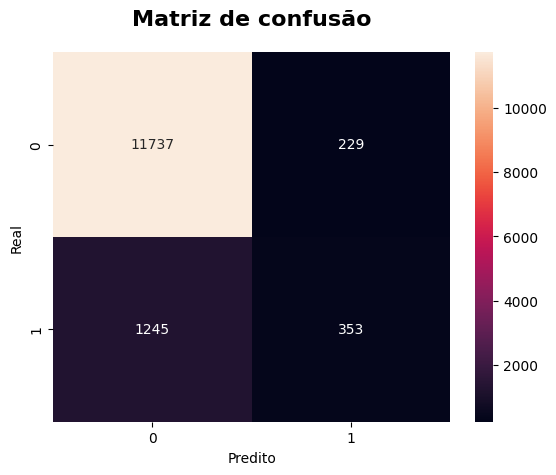

In [61]:
plot_matriz_confusao(y_test, y_pred)

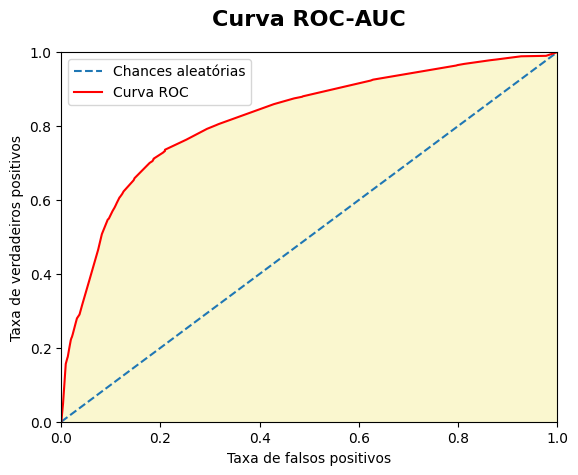

In [62]:
plot_roc_auc(best_model_dectree, X_test, y_test, y_pred)

### Modelo 3 - Random Forest

In [41]:
model_randforest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [42]:
y_pred = model_randforest.predict(X_test)

In [43]:
metricas(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.9046004128575641
    Precisão:   0.6715575620767494
    Revocação:  0.3723404255319149
    F1-Score:   0.47906602254428343
    AUC:        0.6740107609859141
    


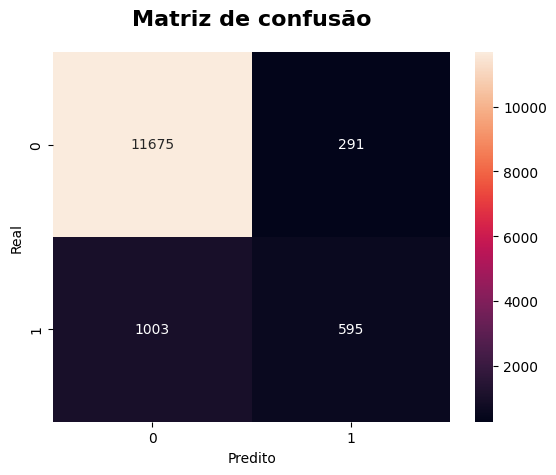

In [44]:
plot_matriz_confusao(y_test, y_pred)

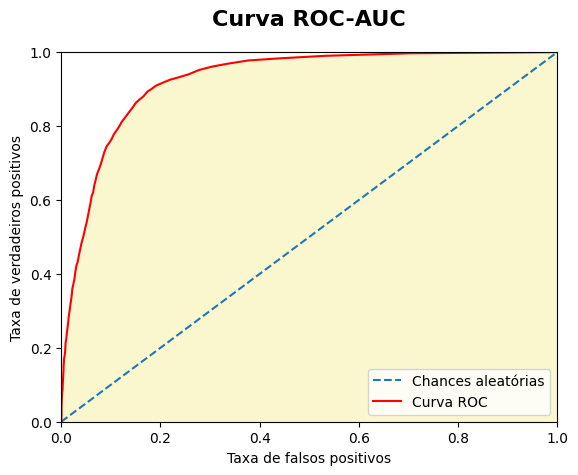

In [47]:
plot_roc_auc(model_randforest, X_test, y_test, y_pred)

#### Ajuste de hiperparâmetros utilizando o GridSearch

In [65]:
model_gscv = RandomForestClassifier()

param_grid = {
    "n_estimators": [20, 100, 200],
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": [None, 10, 50, 100],
    "min_impurity_decrease": [0.0, 0.05, 0.1],
    "ccp_alpha": [0.0, 0.05, 0.1],
    "monotonic_cst": [None, -1, 0, 1]
}

In [66]:
grid_search = GridSearchCV(
    estimator=model_gscv,
    param_grid=param_grid,
    cv=2,
    verbose=1,
    n_jobs=-1
).fit(X_train, y_train)

Fitting 2 folds for each of 93312 candidates, totalling 186624 fits


In [67]:
print("Melhores parâmetros:\n", grid_search.best_params_)

Melhores parâmetros:
 {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'monotonic_cst': None, 'n_estimators': 100}


In [68]:
print("Melhores parâmetros:\n", grid_search.best_score_)

Melhores parâmetros:
 0.9045091320681193


In [69]:
best_model_randtree = grid_search.best_estimator_

In [70]:
y_pred = best_model_dectree.predict(X_test)

In [71]:
metricas(y_test, y_pred)


    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO

    Acurácia:   0.8913299911530522
    Precisão:   0.6065292096219931
    Revocação:  0.22090112640801002
    F1-Score:   0.3238532110091743
    AUC:        0.6008817849990911
    


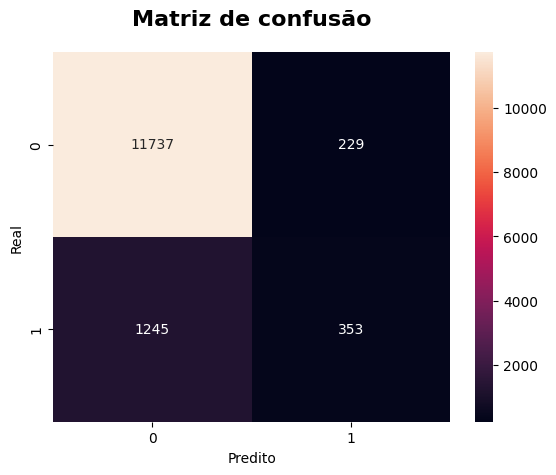

In [72]:
plot_matriz_confusao(y_test, y_pred)

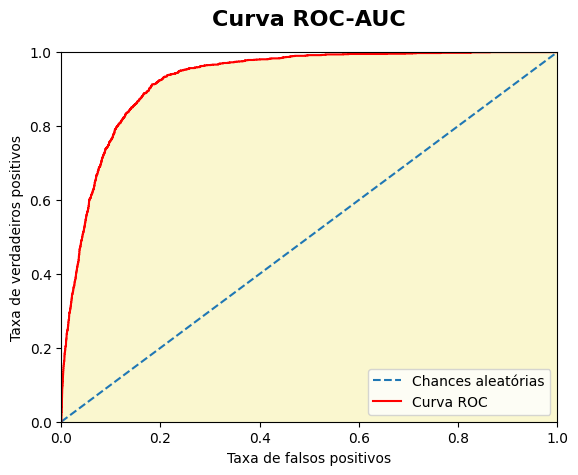

In [73]:
plot_roc_auc(best_model_randtree, X_test, y_test, y_pred)